Found cached dataset json (C:/Users/marco/.cache/huggingface/datasets/json/eur-lex-sum-a5778d28cabf82e9/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['celex_id', 'reference', 'summary'],
        num_rows: 1129
    })
    validation: Dataset({
        features: ['celex_id', 'reference', 'summary'],
        num_rows: 187
    })
    test: Dataset({
        features: ['celex_id', 'reference', 'summary'],
        num_rows: 188
    })
})


Token indices sequence length is longer than the specified maximum sequence length for this model (79639 > 1024). Running this sequence through the model will result in indexing errors


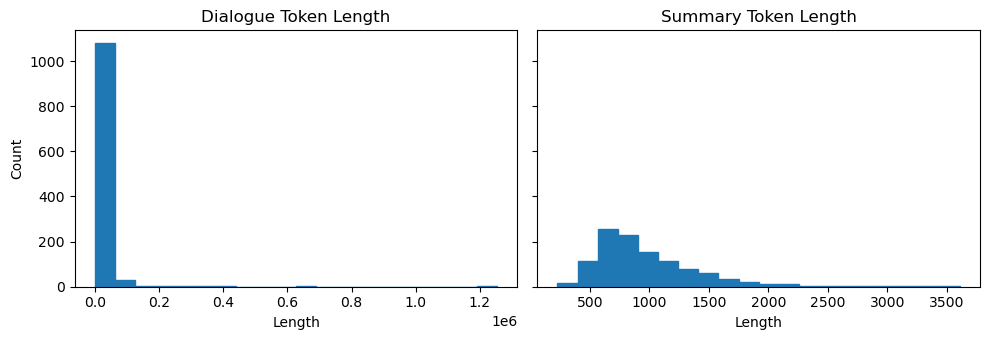

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Loading eur-lex-sum dataset for english language
df = load_dataset("./datasets/eur-lex-sum")
print(df)

# base model
device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "nsi319/legal-pegasus"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  

# plotting sentences lenghth distribution (in terms of token)
d_len = [len(tokenizer.encode(s)) for s in df["train"]["reference"]]
s_len = [len(tokenizer.encode(s)) for s in df["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [7]:
#da riprovare
def summarize_pegasus_long(tokenizer, sample):
    
    summary = ""
    
    # summary token lenght condition
    d_len = len(tokenizer.encode(sample["reference"]))
    
    if(d_len > 1024):
    
    # Summaries of long documents
        start = 0
        window_size = 1024
        total_len = d_len
        loop = True
    
        while loop:
            end = start + window_size
            if end >= total_len:
                loop = False
                end = total_len
                
            # (1) extract window from sample and tokenize it
            input_chuck_tokenizer = tokenizer.encode(sample["reference"][start:end+1], return_tensors='pt',max_length=1024,truncation=True).to(device)    
            # (2) summarize chunk
             with torch.no_grad():
                summary_chunck = model.generate(input_chuck_tokenizer,
                                      num_beams=9,
                                      no_repeat_ngram_size=3,
                                      length_penalty=2.0,
                                      min_length=50,
                                      max_length=150,
                                      early_stopping=True)
                
            # (3) concatenate summaries
            summary = summary + "\n" + [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_chunck][0]       
            start = end
    else:
        # single summary
        input_tokenized = tokenizer.encode(sample["reference"], return_tensors='pt',max_length=1024,truncation=True).to(device)    
        with torch.no_grad():
            summary_ids = model.generate(input_tokenized,
                                          num_beams=9,
                                          no_repeat_ngram_size=3,
                                          length_penalty=2.0,
                                          min_length=150,
                                          max_length=250,
                                          early_stopping=True)
        
        summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
    
    return {"prediction" : summary}

In [37]:
import time
# Record the start time
start_time = time.time()

# Function Call
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

prediction = df["train"].map(lambda sample: summarize_pegasus_long(tokenizer, sample), batched=False)
# Record the end time
end_time = time.time()

# Calculate the execution time
execution_time = (end_time - start_time)/60

print("Execution Time:", execution_time, "minute")

Execution Time: 0.29054838021596274 minute


In [ ]:
from datasets import load_metric
import evaluate

# Record the start time
start_time = time.time()

# Function Call
rouge_score = evaluate.load("rouge")
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

def evaluate_summaries_baseline(dataset):
    return rouge_score.compute(predictions=dataset["prediction"], references=dataset["summary"])

start_time = time.time()

score = evaluate_summaries_baseline(prediction)
print(score)
rouge_dict = dict((rn, round(score[rn], 2)) for rn in rouge_names)

# Record the end time
end_time = time.time()

print(rouge_dict)

# Calculate the execution time
execution_time = (end_time - start_time)/60

print("Execution Time:", execution_time, "minute")

In [39]:
print(prediction[0])


{'celex_id': '32019R0980', 'reference': '21.6.2019\nEN\nOfficial Journal of the European Union\nL 166/26\nCOMMISSION DELEGATED REGULATION (EU) 2019/980\nof 14 March 2019\nsupplementing Regulation (EU) 2017/1129 of the European Parliament and of the Council as regards the format, content, scrutiny and approval of the prospectus to be published when securities are offered to the public or admitted to trading on a regulated market, and repealing Commission Regulation (EC) No 809/2004\n(Text with EEA relevance)\nTHE EUROPEAN COMMISSION,\nHaving regard to the Treaty on the Functioning of the European Union,\nHaving regard to Regulation (EU) 2017/1129 of the European Parliament and of the Council of 14 June 2017 on the prospectus to be published when securities are offered to the public or admitted to trading on a regulated market, and repealing Directive 2003/71/EC (1), and in particular Article 9(14), paragraphs (1) and (2) of Article 13, Articles 14(3), 15(2) and 20(11) thereof,\nWhereas:

In [36]:
print(prediction[0]["summary"])

Prospectus to be published when securities are offered to the public or admitted to trading on a regulated market
Prospectus to be published when securities are offered to the public or admitted to trading on a regulated market
SUMMARY OF:
Regulation (EU) 2017/1129 on the prospectus to be published when securities are offered to the public or admitted to trading on a regulated market
Delegated Regulation (EU) 2019/979 supplementing Regulation (EU) 2017/1129 on regulatory technical standards on key financial information in the summary of a prospectus, the publication and classification of prospectuses, advertisements for securities, supplements to a prospectus, and the notification portal
Delegated Regulation (EU) 2019/980 supplementing Regulation (EU) 2017/1129 on format, content, scrutiny and approval of the prospectus to be published when securities are offered to the public or admitted to trading on a regulated market
Delegated Regulation (EU) 2021/528 supplementing Regulation (EU) 